# Code Test: Solar System

In [1]:
import sys
sys.path.append('../src')
from lightcurve import LightCurve
from ttv import TransitTimingVariations

import numpy as np
import rebound
import matplotlib.pyplot as plt
import astropy.constants as const
import astropy.units as u

from matplotlib import animation
from matplotlib.animation import PillowWriter
from matplotlib import cm

In [10]:
plt.style.use("dark_background")
colors = ['yellow', 'orange', 'pink', 'green', 'red', 'gold', 'brown' , 'blue', 'white']

def plotBodies(ax, names, positions_x, positions_y, ti):
    
    ax.set_xlim(-6,6)
    ax.set_ylim(-6,6)
    
    ps = []
    for i in range(len(names)):
        p = ax.scatter(positions_x[:,i][ti],positions_y[:,i][ti], s=25, color=colors[i], zorder=5)
        ps.append(p)
    
    return ps


def plotOrbitsBodies(ax, names, positions_x, positions_y, ti):
        
    # Plot orbits up to ti and positions at ti
    ps = plotBodies(ax, names, positions_x, positions_y, ti)

    for i in range(len(objects)):
        # Makes it sooo much faster if you plot every 100 values 
        ax.plot(positions_x[:,i][0:ti:100],positions_y[:,i][0:ti:100],label=names[i], linewidth=1, color=colors[i], alpha=0.5)
     
    ax.set_title('Time = {:.3f} years'.format(time[ti]/year))
    ax.set_xlabel('x [au]')
    ax.set_ylabel('y [au]')
    ax.legend(ncols=len(names)/2, loc='upper left')
    ax.grid(alpha=0.2, color='darkgrey')

    
    
def plot_total_lc_section(ax,time, light, ti ):
    
    time = time / year
    
    ax.plot( time[0:ti], light[0:ti])
    ax.set_ylim( min(light)- 0.0001*min(light) , max(light) + 0.0001*max(light) )
    ax.set_xlim(-max(time)/10, max(time) + max(time)/10)
    
    ax.set_xlabel('Time [years]')
    ax.set_ylabel('Relative Brightness')
    ax.grid(alpha=0.2, color='darkgrey')
    

def plot_orbits_and_lc(ax1, ax2, names, positions_x, positions_y, time, light, ti):
    
    plotOrbitsBodies(ax1, names, positions_x, positions_y, ti)
    plot_total_lc_section(ax2,time, light, ti )
    
    
    # --------------------------------------------------------
# Make some functions for the animation 
def init(): #init for initial frame of the animation

    plot_orbits_and_lc(a0, a1, names, positions_x, positions_y, time, light, ti=0)
    return fig,

def animate(i): # changes frame to frame in the animation
    #animate is a function of i which  is the frame number 

    a0.clear()
    a1.clear()
    plt.style.use("dark_background")    
    
    plot_orbits_and_lc(a0, a1, names, positions_x, positions_y, time, light, ti=i*500)

    return fig,

# Run the Simulation 

There are 9 particles in the system


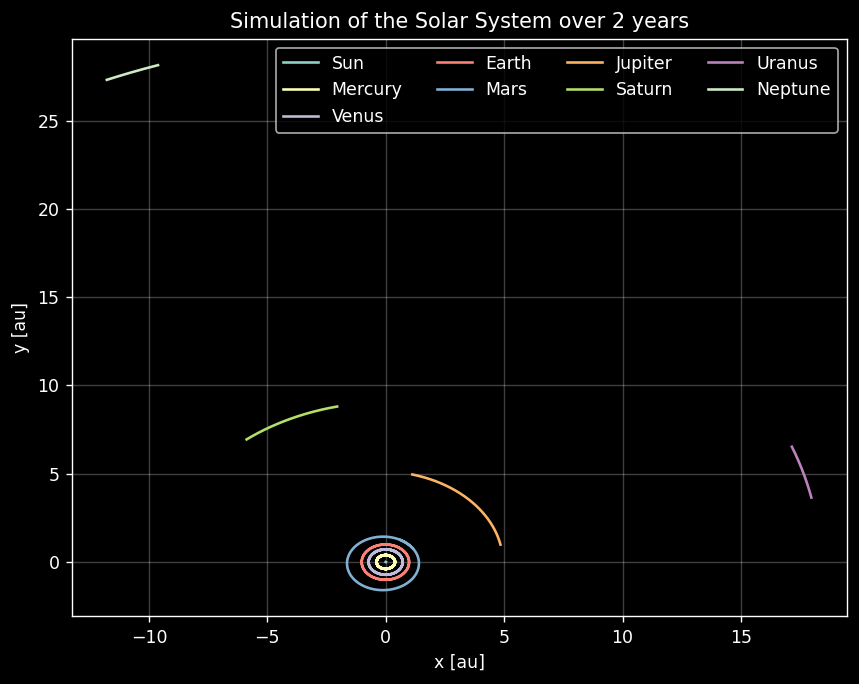

In [14]:
# ----------------------------------------------------------------------------
# Initialize the "bodies"
# ----------------------------------------------------------------------------

# Create a simulation
sim = rebound.Simulation()

# Specify units
sim.units = ('AU', 's', 'Msun')

# --------------
# Solar System 
# --------------

# Add the Sun
sim.add(m=1.0, hash='Sun')

# Add the major planets with their approximate masses, semi-major axes, and eccentricities
# Masses are in solar masses, semi-major axes are in AU, and eccentricities are dimensionless
# (The pomega term is set roughly so that the planets do not all start out along the x axis)

# Mercury
sim.add(m=1.65e-7, a=0.39, e=0,hash="Mercury", pomega=0.9)

# Venus
sim.add(m=2.45e-6, a=0.72, e=0.007,hash="Venus", pomega=0.75)

# Earth
sim.add(m=3.00e-6, a=1.00, e=0.017,hash="Earth", pomega=0.5)

# Mars
sim.add(m=3.22e-7, a=1.52, e=0.093,hash="Mars", pomega=0.6)

# Jupiter
sim.add(m=9.54e-4, a=5.20, e=0.049,hash="Jupiter", pomega=0.2)

# Saturn
sim.add(m=2.86e-4, a=9.58, e=0.056,hash="Saturn", pomega=0.8)

# Uranus
sim.add(m=4.37e-5, a=19.22, e=0.046,hash="Uranus",pomega=0.2)

# Neptune
sim.add(m=5.15e-5, a=30.05, e=0.010,hash="Neptune", pomega=0.9)

print('There are {} particles in the system'.format(sim.N))

# Move to center-of-mass frame
sim.move_to_com()

# ----------------------------------------------------------------------------
# Transit Information 
# ----------------------------------------------------------------------------
radii = np.array([109,0.383,0.949,1,0.532,11.2,9.41,4.01,3.88])
names = ["Sun","Mercury","Venus","Earth","Mars","Jupiter","Saturn","Uranus","Neptune"]

# Retrieve star radius
s_radius = radii[0]

# Find largest radius from planets
max_planet_radius = max(radii[1:])

# Add a buffer to this radius therefore the smaller timestep occurs before transit begins
buffer = 10
max_planet_radius += buffer

# Define the entering and exiting region and ensure units are in AU (match simulation units)
entering = (-s_radius-max_planet_radius)  * const.R_earth.value/const.au.value
exiting = (s_radius+max_planet_radius)  * const.R_earth.value/const.au.value

# ----------------------------------------------------------------------------
# Evolve the System
# Adaptive Time Step
# ----------------------------------------------------------------------------
# Set the integration time
year = 60*60*24*365.25 # seconds/year
t_total = *year

# Create arrays to store positions and time
positions_x = []
positions_y = []
time = []


# Define the timesteps 
large_dt = 1e3
small_dt = 1e3

# Integrate the simulation until total time
while sim.t<=t_total:
    dt = large_dt
    # Record positions
    positions_x.append(np.array([p.x for p in sim.particles]))
    positions_y.append(np.array([p.y for p in sim.particles]))

    # Retrieve position of planets
    planet_pos = positions_y[-1][1:]
    in_transit = np.logical_and(planet_pos>entering, planet_pos<exiting)
    
    # If any planet is about to go into transit use a smaller timestep
    if np.sum(in_transit)>=1:
        if np.any(positions_x[-1][1:][in_transit]>0):
            dt = small_dt

    sim.dt=dt
    time.append(sim.t+sim.dt)
    sim.integrate(sim.t+sim.dt)


# Reshape as ndarrays
positions_x = np.reshape( positions_x, ( len(positions_x), sim.N ) )
positions_y = np.reshape( positions_y, ( len(positions_y), sim.N ) )
time = np.array(time)

# Plot orbit
plt.figure(figsize=(8,6), dpi=125)
plt.title('Simulation of the Solar System over {:.0f} years'.format(sim.t/year))

for i in range(len(radii)):
    plt.plot(positions_x[:,i],positions_y[:,i],label=names[i])

plt.legend(ncols=len(names)/2)
plt.grid(alpha=0.25)
plt.xlabel('x [au]')
plt.ylabel('y [au]')


# ----------------------------------------------------------------------------
# Create Light Curves 
# ----------------------------------------------------------------------------
LC = LightCurve(radii_objects=radii,rad_unit="REarth",dist_unit="AU",xgrid=time)
objects = LC.compute_lightcurve(positions_x.copy(),positions_y.copy(),names)

# Light curve for all time 
start = 0
end = -1
light = LC.get_total_lc(objects,start=start, end=end)

### Create an animation of this

In [16]:
# -------------------------------------------------------- Animate
fig, (a0, a1) = plt.subplots(2,1, height_ratios=[3, 2], figsize=(10,10))
plt.style.use("dark_background")
ani = animation.FuncAnimation(fig, animate, init_func=init,frames=120)
ani.save('solarSystemLightCurve.gif',writer='pillow',fps=500)
plt.close()